# Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from catboost import CatBoost
import catboost as ctb

/Users/akanshajain/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading Data and it's Description

In [2]:
df=pd.read_csv('train.csv')

In [3]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [4]:
df.shape

(43400, 12)

In [5]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [6]:
df['stroke'].value_counts()

0    42617
1      783
Name: stroke, dtype: int64

# Dropping irrelevant columns

In [7]:
#Stroke is highly related with age, hypertension, avg_glucose_level, smoking_status and bmi whereas it partially depends on gender, heart_disease, work_type & Residence_type.

In [8]:
#delete id because that's just a number assigned to each patient no relevance with stroke
del df['id']

In [9]:
#delete ever_married since it can't be good identifier for getting a stroke or not, some people enjoy being married some not which may result to hypertensions or stressed life. 
del df['ever_married']

In [10]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [11]:
#categorical value column name
dfcatname=df.dtypes[df.dtypes=='object'].index
dfcatname

Index(['gender', 'work_type', 'Residence_type', 'smoking_status'], dtype='object')

In [12]:
#continuous value column name
dfconname=[item for item in list(df.columns) if item not in list(dfcatname)]
dfconname

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

In [13]:
df[dfcatname].describe()

,gender,work_type,Residence_type,smoking_status
count,43400,43400,43400,30108
unique,3,5,2,3
top,Female,Private,Urban,never smoked
freq,25665,24834,21756,16053


# BMI missing values

In [14]:
df['bmi'].describe()


count    41938.000000
mean        28.605038
std          7.770020
min         10.100000
25%         23.200000
50%         27.700000
75%         32.900000
max         97.600000
Name: bmi, dtype: float64

In [15]:
df['bmi'].isnull().sum() #found 1462 missing values

1462

In [16]:
#To treat missing value one way is to drop since 1462/43400 is relatively very small number.
#Another is to impute 0/central/statistically estimated values in place of NAN.
#To check if we can impute central value let's plot histogram.

In [17]:
df.hist(column='bmi', figsize=(9,6), bins=20)
#It is seen from histogram that bmi value between 20 to 40 is most common, so it is not entirely unreasonable to do so.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0af68c50>]],
      dtype=object)

In [18]:
#Let's impute central tendency mean in place of missing values

In [19]:
newbmi=np.where(df['bmi'].isnull(),
                df['bmi'].mean(),
                df['bmi'])

In [20]:
df['bmi']=newbmi
df['bmi'].describe()

count    43400.000000
mean        28.605038
std          7.638023
min         10.100000
25%         23.400000
50%         28.100000
75%         32.600000
max         97.600000
Name: bmi, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a13bca390>]],
      dtype=object)

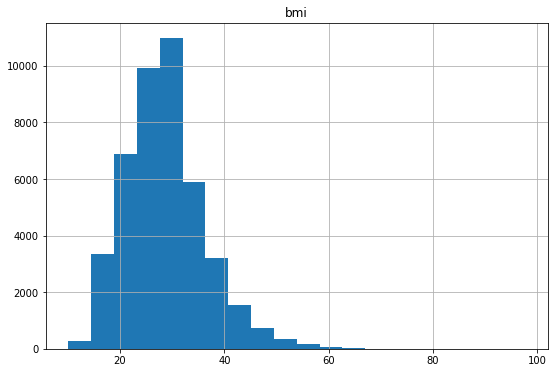

In [21]:
df.hist(column='bmi', figsize=(9,6), bins=20)


# Smoking Status missing values

In [22]:
df['smoking_status'].describe()

count            30108
unique               3
top       never smoked
freq             16053
Name: smoking_status, dtype: object

In [23]:
df['smoking_status'].isnull().sum() 
#Here there are 13236 missing values, which comprises 30% of total data, so dropping is not at all a good idea

13292

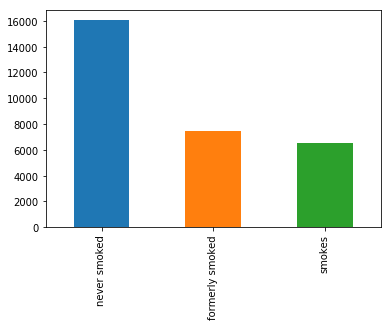

In [24]:
df['smoking_status'].value_counts().plot(kind='bar')

In [25]:
#We could predict it, if it was a continuous variable or there were more reasonable dependent variables
#So for now we'll consider these missing values as a new category say unknown

newss=np.where(df['smoking_status'].isnull(),
                "unknown",
                df['smoking_status'])
df['smoking_status']=newss

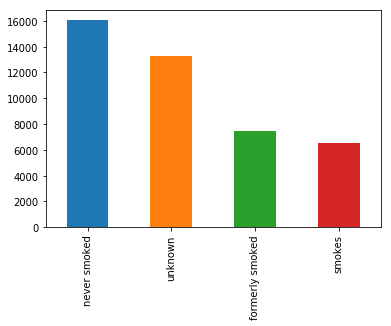

In [26]:
df['smoking_status'].value_counts().plot(kind='bar')

In [27]:
df.count()

gender               43400
age                  43400
hypertension         43400
heart_disease        43400
work_type            43400
Residence_type       43400
avg_glucose_level    43400
bmi                  43400
smoking_status       43400
stroke               43400
dtype: int64

# Outliers

In [28]:
#Checking outliers for numerical features in our dataset

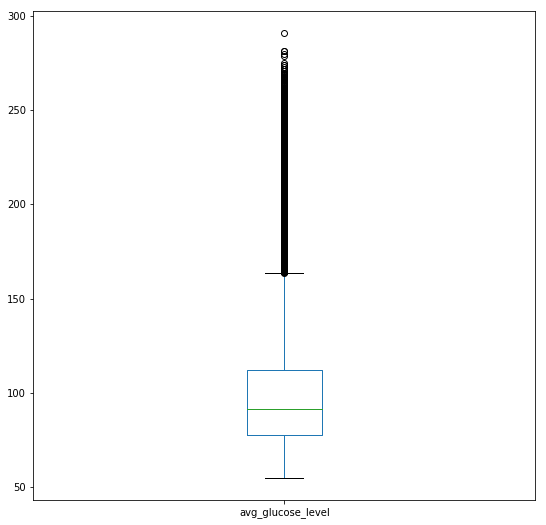

In [29]:
df[dfconname[3]].plot(kind="box",
              figsize=(9,9))

In [30]:
#Dropping outlier
index = np.where(df["avg_glucose_level"] == max(df["avg_glucose_level"]) )
df=df.drop(index[0])

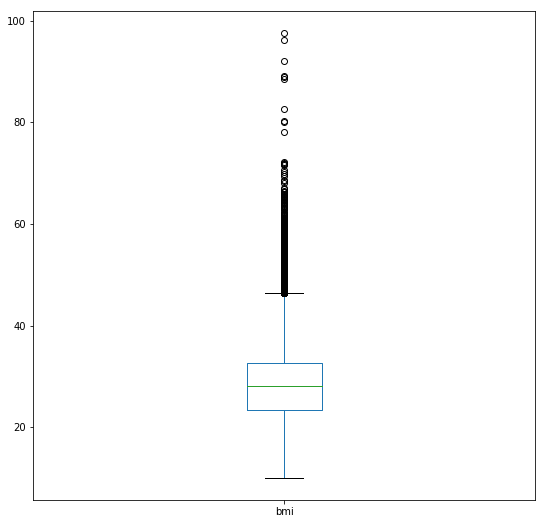

In [31]:
df[dfconname[4]].plot(kind="box",
              figsize=(9,9))

In [32]:
index = np.where(df["bmi"] == max(df["bmi"]) )
df.loc[index]

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1913,Male,17.0,1,0,Private,Rural,61.67,97.6,unknown,0


In [33]:
#bmi value can go extreme upto 54 which is also very rare case, but our dataset has some values greater than 54 also which will act as outliers only, I will prefer removing them keeping margin. It won't affect the data since they're also will keep it realistic.
df=df[df['bmi']<60]
df.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,children,Rural,95.12,18.0,unknown,0
1,Male,58.0,1,0,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,Private,Urban,110.89,17.6,unknown,0
3,Female,70.0,0,0,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,Never_worked,Rural,161.28,19.1,unknown,0


In [34]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43309.000000,43309.00000,43309.000000,43309.000000,43309.000000,43309.000000
mean,42.213087,0.09326,0.047542,104.442117,28.526248,0.018079
std,22.533671,0.29080,0.212798,43.060134,7.438084,0.133240
min,0.080000,0.00000,0.000000,55.000000,10.100000,0.000000
25%,24.000000,0.00000,0.000000,77.540000,23.400000,0.000000
50%,44.000000,0.00000,0.000000,91.570000,28.000000,0.000000
75%,60.000000,0.00000,0.000000,112.030000,32.600000,0.000000
max,82.000000,1.00000,1.000000,281.590000,59.900000,1.000000


In [35]:
df.count()

gender               43309
age                  43309
hypertension         43309
heart_disease        43309
work_type            43309
Residence_type       43309
avg_glucose_level    43309
bmi                  43309
smoking_status       43309
stroke               43309
dtype: int64

# Converting categorical(string) value to numerical values 

In [36]:
df[dfcatname].head()

,gender,work_type,Residence_type,smoking_status
0,Male,children,Rural,unknown
1,Male,Private,Urban,never smoked
2,Female,Private,Urban,unknown
3,Female,Private,Rural,formerly smoked
4,Male,Never_worked,Rural,unknown


In [37]:
#using Label Encoding on columns having less than 3 categories

In [38]:
df['gender']=df['gender'].astype('category')
df['Residence_type'] = df['Residence_type'].astype('category')
# df['ever_married']=df['ever_married'].astype('category')

In [39]:
df['gender']=df['gender'].cat.codes
df['Residence_type']=df['Residence_type'].cat.codes
# df['ever_married']=df['ever_married'].cat.codes

In [40]:
df.head()

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,3.0,0,0,children,0,95.12,18.0,unknown,0
1,1,58.0,1,0,Private,1,87.96,39.2,never smoked,0
2,0,8.0,0,0,Private,1,110.89,17.6,unknown,0
3,0,70.0,0,0,Private,0,69.04,35.9,formerly smoked,0
4,1,14.0,0,0,Never_worked,0,161.28,19.1,unknown,0


In [41]:
#using one hot encoding since this problem set has less features, increase in more columns is not a problem.

In [42]:
df=pd.get_dummies(df, columns=['work_type','smoking_status'], prefix=[ "work",'smoking'])
df.head()

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoking_formerly smoked,smoking_never smoked,smoking_smokes,smoking_unknown
0,1,3.0,0,0,0,95.12,18.0,0,0,0,0,0,1,0,0,0,1
1,1,58.0,1,0,1,87.96,39.2,0,0,0,1,0,0,0,1,0,0
2,0,8.0,0,0,1,110.89,17.6,0,0,0,1,0,0,0,0,0,1
3,0,70.0,0,0,0,69.04,35.9,0,0,0,1,0,0,1,0,0,0
4,1,14.0,0,0,0,161.28,19.1,0,0,1,0,0,0,0,0,0,1


# Classification

In [43]:
df.describe()

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,stroke,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoking_formerly smoked,smoking_never smoked,smoking_smokes,smoking_unknown
count,43309.000000,43309.000000,43309.00000,43309.000000,43309.000000,43309.000000,43309.000000,43309.000000,43309.000000,43309.000000,43309.000000,43309.000000,43309.000000,43309.000000,43309.000000,43309.000000,43309.000000
mean,0.409037,42.213087,0.09326,0.047542,0.501328,104.442117,28.526248,0.018079,0.125378,0.004087,0.571937,0.156480,0.142118,0.172689,0.369808,0.151123,0.306380
std,0.492178,22.533671,0.29080,0.212798,0.500004,43.060134,7.438084,0.133240,0.331151,0.063799,0.494804,0.363314,0.349175,0.377983,0.482758,0.358173,0.460995
min,0.000000,0.080000,0.00000,0.000000,0.000000,55.000000,10.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,0.00000,0.000000,0.000000,77.540000,23.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,44.000000,0.00000,0.000000,1.000000,91.570000,28.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,60.000000,0.00000,0.000000,1.000000,112.030000,32.600000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,2.000000,82.000000,1.00000,1.000000,1.000000,281.590000,59.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
# split data into X and y
X = df.loc[:, df.columns != 'stroke']
Y = df['stroke']

In [45]:
# split data into X and y and selecting only what i feel is important
# X = df.drop(['stroke','Residence_type','work_Govt_job','work_Never_worked','work_Private','work_Self-employed','work_children'],axis=1)
# Y = df['stroke']

In [46]:
# Manual Sampling
# dfone=df[df['stroke']==0]
# dfzero=df[df['stroke']==1]
# dfsample= dfone.sample(1000)
# dfnew=pd.concat([dfsample,dfzero])
# # split data into X and y
# X = dfnew.loc[:, df.columns != 'stroke']
# Y = dfnew['stroke']

In [47]:
# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [48]:
y_train.value_counts()

0    28478
1      539
Name: stroke, dtype: int64

In [49]:
y_val.value_counts()

0    14048
1      244
Name: stroke, dtype: int64

# Catboost Training

In [50]:
catmodel=CatBoostClassifier()
catmodel.fit(X_train, y_train)

0:	learn: 0.6317757	total: 115ms	remaining: 1m 54s
1:	learn: 0.5750370	total: 171ms	remaining: 1m 25s
2:	learn: 0.5223247	total: 229ms	remaining: 1m 16s
3:	learn: 0.4774069	total: 298ms	remaining: 1m 14s
4:	learn: 0.4325527	total: 375ms	remaining: 1m 14s
5:	learn: 0.3981234	total: 432ms	remaining: 1m 11s
6:	learn: 0.3688520	total: 492ms	remaining: 1m 9s
7:	learn: 0.3382013	total: 532ms	remaining: 1m 5s
8:	learn: 0.3137321	total: 611ms	remaining: 1m 7s
9:	learn: 0.2902774	total: 693ms	remaining: 1m 8s
10:	learn: 0.2707026	total: 762ms	remaining: 1m 8s
11:	learn: 0.2535742	total: 869ms	remaining: 1m 11s
12:	learn: 0.2382810	total: 944ms	remaining: 1m 11s
13:	learn: 0.2239530	total: 999ms	remaining: 1m 10s
14:	learn: 0.2116312	total: 1.05s	remaining: 1m 8s
15:	learn: 0.2005572	total: 1.13s	remaining: 1m 9s
16:	learn: 0.1902421	total: 1.2s	remaining: 1m 9s
17:	learn: 0.1812683	total: 1.27s	remaining: 1m 9s
18:	learn: 0.1732496	total: 1.33s	remaining: 1m 8s
19:	learn: 0.1652482	total: 1.4s	

165:	learn: 0.0713022	total: 9.15s	remaining: 46s
166:	learn: 0.0712478	total: 9.22s	remaining: 46s
167:	learn: 0.0711763	total: 9.3s	remaining: 46.1s
168:	learn: 0.0711106	total: 9.35s	remaining: 46s
169:	learn: 0.0710805	total: 9.39s	remaining: 45.9s
170:	learn: 0.0710479	total: 9.43s	remaining: 45.7s
171:	learn: 0.0710271	total: 9.48s	remaining: 45.6s
172:	learn: 0.0710264	total: 9.51s	remaining: 45.5s
173:	learn: 0.0710013	total: 9.57s	remaining: 45.4s
174:	learn: 0.0709687	total: 9.64s	remaining: 45.5s
175:	learn: 0.0709233	total: 9.7s	remaining: 45.4s
176:	learn: 0.0708940	total: 9.75s	remaining: 45.3s
177:	learn: 0.0708689	total: 9.81s	remaining: 45.3s
178:	learn: 0.0708494	total: 9.87s	remaining: 45.3s
179:	learn: 0.0708109	total: 9.91s	remaining: 45.1s
180:	learn: 0.0707884	total: 9.94s	remaining: 45s
181:	learn: 0.0707577	total: 9.98s	remaining: 44.9s
182:	learn: 0.0707246	total: 10s	remaining: 44.7s
183:	learn: 0.0706944	total: 10.1s	remaining: 44.6s
184:	learn: 0.0706159	to

325:	learn: 0.0670123	total: 16.7s	remaining: 34.4s
326:	learn: 0.0670018	total: 16.7s	remaining: 34.4s
327:	learn: 0.0669878	total: 16.7s	remaining: 34.3s
328:	learn: 0.0669685	total: 16.8s	remaining: 34.3s
329:	learn: 0.0669443	total: 16.9s	remaining: 34.3s
330:	learn: 0.0669059	total: 16.9s	remaining: 34.2s
331:	learn: 0.0668955	total: 17s	remaining: 34.2s
332:	learn: 0.0668852	total: 17s	remaining: 34.1s
333:	learn: 0.0668569	total: 17.1s	remaining: 34s
334:	learn: 0.0668564	total: 17.1s	remaining: 34s
335:	learn: 0.0668397	total: 17.1s	remaining: 33.9s
336:	learn: 0.0668181	total: 17.2s	remaining: 33.8s
337:	learn: 0.0667925	total: 17.2s	remaining: 33.7s
338:	learn: 0.0667803	total: 17.3s	remaining: 33.7s
339:	learn: 0.0667692	total: 17.3s	remaining: 33.6s
340:	learn: 0.0667530	total: 17.3s	remaining: 33.5s
341:	learn: 0.0667327	total: 17.4s	remaining: 33.4s
342:	learn: 0.0667084	total: 17.4s	remaining: 33.4s
343:	learn: 0.0666852	total: 17.5s	remaining: 33.3s
344:	learn: 0.066652

488:	learn: 0.0639623	total: 23.3s	remaining: 24.3s
489:	learn: 0.0639533	total: 23.3s	remaining: 24.3s
490:	learn: 0.0639462	total: 23.3s	remaining: 24.2s
491:	learn: 0.0638931	total: 23.4s	remaining: 24.1s
492:	learn: 0.0638705	total: 23.4s	remaining: 24.1s
493:	learn: 0.0638491	total: 23.5s	remaining: 24.1s
494:	learn: 0.0638286	total: 23.5s	remaining: 24s
495:	learn: 0.0638056	total: 23.6s	remaining: 24s
496:	learn: 0.0637969	total: 23.6s	remaining: 23.9s
497:	learn: 0.0637737	total: 23.7s	remaining: 23.8s
498:	learn: 0.0637477	total: 23.7s	remaining: 23.8s
499:	learn: 0.0637330	total: 23.7s	remaining: 23.7s
500:	learn: 0.0637209	total: 23.8s	remaining: 23.7s
501:	learn: 0.0636907	total: 23.9s	remaining: 23.7s
502:	learn: 0.0636747	total: 24s	remaining: 23.7s
503:	learn: 0.0636628	total: 24.1s	remaining: 23.7s
504:	learn: 0.0636452	total: 24.2s	remaining: 23.7s
505:	learn: 0.0636249	total: 24.3s	remaining: 23.7s
506:	learn: 0.0636160	total: 24.4s	remaining: 23.7s
507:	learn: 0.0636

648:	learn: 0.0613990	total: 30.7s	remaining: 16.6s
649:	learn: 0.0613764	total: 30.8s	remaining: 16.6s
650:	learn: 0.0613678	total: 30.8s	remaining: 16.5s
651:	learn: 0.0613434	total: 30.8s	remaining: 16.5s
652:	learn: 0.0613400	total: 30.9s	remaining: 16.4s
653:	learn: 0.0613254	total: 30.9s	remaining: 16.3s
654:	learn: 0.0613039	total: 30.9s	remaining: 16.3s
655:	learn: 0.0612956	total: 31s	remaining: 16.2s
656:	learn: 0.0612798	total: 31s	remaining: 16.2s
657:	learn: 0.0612707	total: 31.1s	remaining: 16.1s
658:	learn: 0.0612556	total: 31.1s	remaining: 16.1s
659:	learn: 0.0612429	total: 31.1s	remaining: 16s
660:	learn: 0.0612333	total: 31.2s	remaining: 16s
661:	learn: 0.0612239	total: 31.2s	remaining: 15.9s
662:	learn: 0.0612133	total: 31.2s	remaining: 15.9s
663:	learn: 0.0611922	total: 31.3s	remaining: 15.8s
664:	learn: 0.0611687	total: 31.3s	remaining: 15.8s
665:	learn: 0.0611557	total: 31.3s	remaining: 15.7s
666:	learn: 0.0611500	total: 31.4s	remaining: 15.7s
667:	learn: 0.061141

807:	learn: 0.0593082	total: 38.7s	remaining: 9.19s
808:	learn: 0.0592933	total: 38.7s	remaining: 9.14s
809:	learn: 0.0592854	total: 38.8s	remaining: 9.1s
810:	learn: 0.0592837	total: 38.8s	remaining: 9.05s
811:	learn: 0.0592749	total: 38.9s	remaining: 9.01s
812:	learn: 0.0592687	total: 39s	remaining: 8.96s
813:	learn: 0.0592538	total: 39s	remaining: 8.92s
814:	learn: 0.0592398	total: 39.1s	remaining: 8.87s
815:	learn: 0.0592357	total: 39.1s	remaining: 8.83s
816:	learn: 0.0592189	total: 39.2s	remaining: 8.78s
817:	learn: 0.0592011	total: 39.3s	remaining: 8.73s
818:	learn: 0.0591934	total: 39.3s	remaining: 8.69s
819:	learn: 0.0591916	total: 39.4s	remaining: 8.64s
820:	learn: 0.0591591	total: 39.4s	remaining: 8.6s
821:	learn: 0.0591461	total: 39.5s	remaining: 8.55s
822:	learn: 0.0591194	total: 39.5s	remaining: 8.5s
823:	learn: 0.0591057	total: 39.6s	remaining: 8.46s
824:	learn: 0.0590935	total: 39.6s	remaining: 8.41s
825:	learn: 0.0590693	total: 39.7s	remaining: 8.36s
826:	learn: 0.05905

966:	learn: 0.0573972	total: 48.4s	remaining: 1.65s
967:	learn: 0.0573758	total: 48.5s	remaining: 1.6s
968:	learn: 0.0573654	total: 48.6s	remaining: 1.55s
969:	learn: 0.0573605	total: 48.6s	remaining: 1.5s
970:	learn: 0.0573473	total: 48.7s	remaining: 1.45s
971:	learn: 0.0573379	total: 48.7s	remaining: 1.4s
972:	learn: 0.0573280	total: 48.8s	remaining: 1.35s
973:	learn: 0.0573265	total: 48.8s	remaining: 1.3s
974:	learn: 0.0573185	total: 48.8s	remaining: 1.25s
975:	learn: 0.0573045	total: 48.9s	remaining: 1.2s
976:	learn: 0.0572951	total: 48.9s	remaining: 1.15s
977:	learn: 0.0572873	total: 49s	remaining: 1.1s
978:	learn: 0.0572712	total: 49s	remaining: 1.05s
979:	learn: 0.0572657	total: 49s	remaining: 1s
980:	learn: 0.0572525	total: 49.1s	remaining: 951ms
981:	learn: 0.0572442	total: 49.1s	remaining: 901ms
982:	learn: 0.0572385	total: 49.2s	remaining: 851ms
983:	learn: 0.0572345	total: 49.2s	remaining: 800ms
984:	learn: 0.0572310	total: 49.3s	remaining: 750ms
985:	learn: 0.0572211	total

In [51]:
y_pred_cat = catmodel.predict(X_val)

In [52]:
# evaluate predictions
accuracycat = accuracy_score(y_val, y_pred_cat)
print("Accuracy: %.2f%%" % (accuracycat * 100.0))

Accuracy: 98.28%


In [53]:
print("AUC ROC: %.2f%%" % roc_auc_score(y_val, y_pred_cat))

AUC ROC: 0.50%


# Transforming Test data

In [54]:
test=pd.read_csv('test.csv')

In [55]:
del test['ever_married']

In [56]:
newss=np.where(test['smoking_status'].isnull(),
                "unknown",
                test['smoking_status'])
test['smoking_status']=newss

In [57]:
test.isnull().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
dtype: bool

In [58]:
newbmi=np.where(test['bmi'].isnull(),test['bmi'].mean(),test['bmi'])
test['bmi']=newbmi

In [59]:
test.isnull().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                  False
smoking_status       False
dtype: bool

In [60]:
test['gender']=test['gender'].astype('category')
test['Residence_type'] = test['Residence_type'].astype('category')
test['gender']=test['gender'].cat.codes
test['Residence_type']=test['Residence_type'].cat.codes
# test['ever_married']=test['ever_married'].astype('category')
# test['ever_married']=test['ever_married'].cat.codes
test=pd.get_dummies(test, columns=['work_type','smoking_status'], prefix=[ "work",'smoking'])
test

,id,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoking_formerly smoked,smoking_never smoked,smoking_smokes,smoking_unknown
0,36306,1,80.0,0,0,1,83.84,21.100000,0,0,1,0,0,1,0,0,0
1,61829,0,74.0,0,1,0,179.50,26.000000,0,0,0,1,0,1,0,0,0
2,14152,0,14.0,0,0,0,95.16,21.200000,0,0,0,0,1,0,0,0,1
3,12997,1,28.0,0,0,1,94.76,23.400000,0,0,1,0,0,0,0,0,1
4,40801,0,63.0,0,0,0,83.57,27.600000,1,0,0,0,0,0,1,0,0
5,9348,0,66.0,1,0,1,219.98,32.200000,0,0,1,0,0,0,1,0,0
6,51550,0,49.0,0,0,0,74.03,25.100000,0,0,0,1,0,0,0,0,1
7,60512,1,46.0,0,0,1,120.80,32.500000,1,0,0,0,0,0,1,0,0
8,31309,0,75.0,0,0,0,78.71,28.000000,0,0,0,1,0,0,1,0,0
9,39199,1,75.0,0,0,1,77.20,25.700000,0,0,0,1,0,0,0,1,0


In [61]:
# split data into X and y and selecting only what i feel is important
# X_test = test.drop(['id','Residence_type','work_Govt_job','work_Never_worked','work_Private','work_Self-employed','work_children'],axis=1)
# testid=test['id']


In [62]:
X_test = test.loc[:, test.columns != 'id']
testid=test['id']
X_test

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,smoking_formerly smoked,smoking_never smoked,smoking_smokes,smoking_unknown
0,1,80.0,0,0,1,83.84,21.100000,0,0,1,0,0,1,0,0,0
1,0,74.0,0,1,0,179.50,26.000000,0,0,0,1,0,1,0,0,0
2,0,14.0,0,0,0,95.16,21.200000,0,0,0,0,1,0,0,0,1
3,1,28.0,0,0,1,94.76,23.400000,0,0,1,0,0,0,0,0,1
4,0,63.0,0,0,0,83.57,27.600000,1,0,0,0,0,0,1,0,0
5,0,66.0,1,0,1,219.98,32.200000,0,0,1,0,0,0,1,0,0
6,0,49.0,0,0,0,74.03,25.100000,0,0,0,1,0,0,0,0,1
7,1,46.0,0,0,1,120.80,32.500000,1,0,0,0,0,0,1,0,0
8,0,75.0,0,0,0,78.71,28.000000,0,0,0,1,0,0,1,0,0
9,1,75.0,0,0,1,77.20,25.700000,0,0,0,1,0,0,0,1,0


# Predicting user test data using Catboost

In [63]:
# make predictions for test data
Y_test_label_cat= catmodel.predict(X_test)
Y_test_prob_cat= catmodel.predict_proba(X_test)

In [64]:
Y_test_cat=[None]*len(X_test)
for i in range(len(X_test)):
    Y_test_cat[i]=Y_test_prob_cat[i][1]
Y_test_cat[:5]

[0.0601973230256568,
 0.030544869132216903,
 4.388038697630178e-06,
 0.00015428063672432923,
 0.00763771056144704]

In [65]:
sample=pd.DataFrame()
sample['id']=testid
sample['stroke']=Y_test_cat
sample.to_csv('samplesubmission.csv', index=False)